<a href="https://colab.research.google.com/github/Henriquerocha2000/DesafioTecnicoTraineeMagalu/blob/main/Estudo_Logistico_CD_Magalu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo logístico - Novo Centro de distribuição no Nordeste
Cenário

O Magalu precisa abrir um novo CD no Nordeste para agilizar as entregas e a diretoria está em dúvida entre duas cidades: Recife e Salvador. Através de análises utilizando a inteligência artificial, defina:

* Qual das duas cidades apresenta a localização mais estratégica para a empresa?
* Quais são os principais fatores que sustentam essa decisão?
* Quais ferramentas e metodologias foram utilizadas para fundamentar o seu case?

# Critérios a serem analisados.
* Análise de custos imobiliários em ambas as cidades.
* Mapas de malha viária mostrando os tempos de entrega para as principais capitais da região a partir de cada cidade.
* Estudo demográfico sobre o potencial de consumo nos estados vizinhos.

# Fontes
* Latitude and Longitude Finder:https://www.latlong.net
* API	Aviationstack : https://aviationstack.com
* Dados Indice Fipezao para alugueis comerciais: https://www.fipe.org.br/pt-br/indices/fipezap/#indice-fipezap-comercial .
* Build Your Own Flight Tracking Application with Python: https://www.youtube.com/watch?v=w2ALMxXBAGw&t=289s
* VIvaReal :https://www.vivareal.com.br
* DataZap : https://www.datazap.com.br/conteudos-fipezap
* Movimento econômico :https://movimentoeconomico.com.br/economia/2025/07/02/com-194-cidades-no-clube-do-bilhao-ne-e-a-2a-maior-forca-consumidora-do-pais/?utm_source=chatgpt.com

# Imports

In [39]:
import pandas as pd
import requests
from geopy.distance import geodesic
import plotly.graph_objects as go


# Críterios apresentados.

In [40]:
#Disntância com base na malha viária
#Utilizando uma chave api gratuita fornecida pela API Aviationstack para acessar os dados das linhas aérias.
#Vídeo de referência Build Your Own Flight Tracking Application with Python.
#Dificuldade na implementação no meu caso, acabei recorrendo ao Deepseek.
# chave de API da Aviationstack
api_key = "1097aa41041701cc9572868c97aa7a85"

# Aeroportos das principais capitais (códigos IATA)
aeroportos = {
    "Salvador": "SSA",
    "Recife": "REC",
    "Fortaleza": "FOR",
    "São Luís": "SLZ",
    "Teresina": "THE",
    "Maceió": "MCZ",
    "Aracaju": "AJU",
    "Natal": "NAT",
    "João Pessoa": "JPA"
}

# Coordenadas aproximadas para o mapa
coordenadas = {
    "Salvador": [-12.9714, -38.5014],
    "Recife": [-8.0476, -34.8770],
    "Fortaleza": [-3.7172, -38.5437],
    "São Luís": [-2.5297, -44.3028],
    "Teresina": [-5.0892, -42.8034],
    "Maceió": [-9.6658, -35.7350],
    "Aracaju": [-10.9472, -37.0731],
    "Natal": [-5.7945, -35.2110],
    "João Pessoa": [-7.1153, -34.8641]
}

# Função para consultar voos e pegar duração (em horas)
def consultar_tempo_voo(origem_iata, destino_iata):
    url = f"http://api.aviationstack.com/v1/flights?access_key={api_key}&dep_iata={origem_iata}&arr_iata={destino_iata}&limit=1"
    resposta = requests.get(url).json()
    try:
        voo = resposta['data'][0]
        duracao = voo.get('flight_duration', None)  # duração em minutos, se disponível
        if duracao:
            return float(duracao)/60  # converter para horas
        else:
            return None
    except (IndexError, KeyError):
        # Caso não tenha voo na API, usar valor aproximado fictício
        return None

# Criar dataframe com tempos de voo
dados = []
for origem in ["Salvador", "Recife"]:
    for destino in aeroportos:
        if destino != origem:
            tempo = consultar_tempo_voo(aeroportos[origem], aeroportos[destino])
            if not tempo:  # se não houver dados reais, colocar tempo aproximado
                tempo = round(abs(coordenadas[origem][0]-coordenadas[destino][0]) +
                             abs(coordenadas[origem][1]-coordenadas[destino][1]), 2)
            dados.append([origem, destino, tempo, coordenadas[destino][0], coordenadas[destino][1]])

df_voos = pd.DataFrame(dados, columns=['Origem', 'Destino', 'Tempo_h', 'Lat', 'Lon'])
print(df_voos)

      Origem      Destino  Tempo_h      Lat      Lon
0   Salvador       Recife     8.55  -8.0476 -34.8770
1   Salvador    Fortaleza     9.30  -3.7172 -38.5437
2   Salvador     São Luís    16.24  -2.5297 -44.3028
3   Salvador     Teresina    12.18  -5.0892 -42.8034
4   Salvador       Maceió     6.07  -9.6658 -35.7350
5   Salvador      Aracaju     3.45 -10.9472 -37.0731
6   Salvador        Natal    10.47  -5.7945 -35.2110
7   Salvador  João Pessoa     9.49  -7.1153 -34.8641
8     Recife     Salvador     8.55 -12.9714 -38.5014
9     Recife    Fortaleza     8.00  -3.7172 -38.5437
10    Recife     São Luís    14.94  -2.5297 -44.3028
11    Recife     Teresina    10.88  -5.0892 -42.8034
12    Recife       Maceió     2.48  -9.6658 -35.7350
13    Recife      Aracaju     5.10 -10.9472 -37.0731
14    Recife        Natal     2.59  -5.7945 -35.2110
15    Recife  João Pessoa     0.95  -7.1153 -34.8641


In [41]:
#Criação de um data frame com base na pesquisa de alugueis de pontos comerciais com no mínimo 1000m².
#Dados forma baeados no site Vivareal.
#Criados em   02/09/2025
# Imóveis de Salvador
salvador = [
    {"Cidade": "Salvador", "Local": "Brotas", "Tamanho_m2": 3500, "Preco_R$": 95000},
    {"Cidade": "Salvador", "Local": "Imbuí", "Tamanho_m2": 1200, "Preco_R$": 50000},
    {"Cidade": "Salvador", "Local": "Mares", "Tamanho_m2": 1174, "Preco_R$": 15000},
    {"Cidade": "Salvador", "Local": "Itapuã", "Tamanho_m2": 1135, "Preco_R$": 35000},
    {"Cidade": "Salvador", "Local": "Paralela", "Tamanho_m2": 1605, "Preco_R$": 250000},
    {"Cidade": "Salvador", "Local": "Cabula", "Tamanho_m2": 1120, "Preco_R$": 60000},
    {"Cidade": "Salvador", "Local": "Vila Ruy Barbosa", "Tamanho_m2": 1000, "Preco_R$": 16000},
    {"Cidade": "Salvador", "Local": "Baixa dos Sapateiros", "Tamanho_m2": 1000, "Preco_R$": 18000},
    {"Cidade": "Salvador", "Local": "Comércio", "Tamanho_m2": 54100, "Preco_R$": 15000},
    {"Cidade": "Salvador", "Local": "Paralela", "Tamanho_m2": 1605, "Preco_R$": 170000},
    {"Cidade": "Salvador", "Local": "Pituba", "Tamanho_m2": 5150, "Preco_R$": 170000},
    {"Cidade": "Salvador", "Local": "Praia do Flamengo", "Tamanho_m2": 1000, "Preco_R$": 30000},
    {"Cidade": "Salvador", "Local": "Calçada", "Tamanho_m2": 1014, "Preco_R$": 20000},
    {"Cidade": "Salvador", "Local": "Vila Ruy Barbosa", "Tamanho_m2": 2000, "Preco_R$": 70000},
    {"Cidade": "Salvador", "Local": "Horto Florestal", "Tamanho_m2": 1047, "Preco_R$": 45000},
    {"Cidade": "Salvador", "Local": "Brotas", "Tamanho_m2": 5090, "Preco_R$": 170000},
    {"Cidade": "Salvador", "Local": "Cajazeiras VIII", "Tamanho_m2": 1200, "Preco_R$": 30000},
    {"Cidade": "Salvador", "Local": "Matatu", "Tamanho_m2": 1050, "Preco_R$": 19000},
    {"Cidade": "Salvador", "Local": "Federação", "Tamanho_m2": 9504, "Preco_R$": 190000},
    {"Cidade": "Salvador", "Local": "Sete de Abril", "Tamanho_m2": 1054, "Preco_R$": 12500},
    {"Cidade": "Salvador", "Local": "Federação", "Tamanho_m2": 9500, "Preco_R$": 180000},
    {"Cidade": "Salvador", "Local": "Calçada", "Tamanho_m2": 1014, "Preco_R$": 20000},
    {"Cidade": "Salvador", "Local": "Caminho das Árvores", "Tamanho_m2": 1186, "Preco_R$": 60000},
    {"Cidade": "Salvador", "Local": "Imbuí", "Tamanho_m2": 1423, "Preco_R$": 45000},
    {"Cidade": "Salvador", "Local": "Nazaré", "Tamanho_m2": 8000, "Preco_R$": 40000},
    {"Cidade": "Salvador", "Local": "Barbalho", "Tamanho_m2": 1910, "Preco_R$": 20000},
    {"Cidade": "Salvador", "Local": "Ondina", "Tamanho_m2": 1190, "Preco_R$": 120000},
    {"Cidade": "Salvador", "Local": "Uruguai", "Tamanho_m2": 3598, "Preco_R$": 68000},
    {"Cidade": "Salvador", "Local": "Engenho Velho de Brotas", "Tamanho_m2": 1708, "Preco_R$": 35000},
    {"Cidade": "Salvador", "Local": "Brotas", "Tamanho_m2": 4000, "Preco_R$": 99999},
    {"Cidade": "Salvador", "Local": "Pituaçu", "Tamanho_m2": 1100, "Preco_R$": 45000},
    {"Cidade": "Salvador", "Local": "Brotas", "Tamanho_m2": 1800, "Preco_R$": 125000},
]
# Imóveis de Recife
recife = [
    {"Cidade": "Recife", "Local": "Boa Viagem", "Tamanho_m2": 6751, "Preco_R$": 3000},
    {"Cidade": "Recife", "Local": "Imbiribeira", "Tamanho_m2": 2500, "Preco_R$": 90000},
    {"Cidade": "Recife", "Local": "Santo Amaro", "Tamanho_m2": 3000, "Preco_R$": 60000},
    {"Cidade": "Recife", "Local": "Boa Viagem", "Tamanho_m2": 1300, "Preco_R$": 70000},
    {"Cidade": "Recife", "Local": "Santo Antônio", "Tamanho_m2": 1282, "Preco_R$": 11000},
    {"Cidade": "Recife", "Local": "Boa Viagem", "Tamanho_m2": 1800, "Preco_R$": 100000},
    {"Cidade": "Recife", "Local": "Espinheiro", "Tamanho_m2": 1180, "Preco_R$": 38000},
    {"Cidade": "Recife", "Local": "Boa Viagem", "Tamanho_m2": 1000, "Preco_R$": 75000},
    {"Cidade": "Recife", "Local": "Santo Amaro", "Tamanho_m2": 1700, "Preco_R$": 17000},
    {"Cidade": "Recife", "Local": "Santo Antônio", "Tamanho_m2": 2343, "Preco_R$": 95200},
    {"Cidade": "Recife", "Local": "Cordeiro", "Tamanho_m2": 1040, "Preco_R$": 30000},
    {"Cidade": "Recife", "Local": "Boa Vista", "Tamanho_m2": 2202, "Preco_R$": 49000},
    {"Cidade": "Recife", "Local": "Boa Vista", "Tamanho_m2": 1241, "Preco_R$": 16000},
    {"Cidade": "Recife", "Local": "Boa Vista", "Tamanho_m2": 1625, "Preco_R$": 18000},
    {"Cidade": "Recife", "Local": "Boa Vista", "Tamanho_m2": 5206, "Preco_R$": 62000},
    {"Cidade": "Recife", "Local": "Jordão", "Tamanho_m2": 1840, "Preco_R$": 38000},
    {"Cidade": "Recife", "Local": "Boa Vista", "Tamanho_m2": 1669, "Preco_R$": 16000},
    {"Cidade": "Recife", "Local": "Soledade", "Tamanho_m2": 1160, "Preco_R$": 30000},
    {"Cidade": "Recife", "Local": "Espinheiro", "Tamanho_m2": 1180, "Preco_R$": 37900},
    {"Cidade": "Recife", "Local": "Bongi", "Tamanho_m2": 1200, "Preco_R$": 22000},
    {"Cidade": "Recife", "Local": "Santo Antônio", "Tamanho_m2": 1280, "Preco_R$": 27000},
    {"Cidade": "Recife", "Local": "Espinheiro", "Tamanho_m2": 1559, "Preco_R$": 18000},
    {"Cidade": "Recife", "Local": "Boa Viagem", "Tamanho_m2": 18000, "Preco_R$": 115000},
    {"Cidade": "Recife", "Local": "Boa Viagem", "Tamanho_m2": 1800, "Preco_R$": 110000},
    {"Cidade": "Recife", "Local": "Santo Antônio", "Tamanho_m2": 1150, "Preco_R$": 45000},
]

#Juntando os datasframes

df = pd.DataFrame(salvador + recife)

# Criando uma coluna para calcular valor por m²
df["Preco_m2"] = df["Preco_R$"] / df["Tamanho_m2"]

# Estatísticas comparativas
comparacao = df.groupby("Cidade")["Preco_m2"].agg(["mean", "min", "max"]).reset_index()

# Identificar menor e maior aluguel por m²
menor = df.loc[df["Preco_m2"].idxmin()]
maior = df.loc[df["Preco_m2"].idxmax()]

print("📊 Comparação entre cidades:")
print(comparacao, "\n")

print("🏠 Menor aluguel por m² (mais vantajoso):")
print(menor, "\n")

print("💸 Maior aluguel por m² (mais caro):")
print(maior)


📊 Comparação entre cidades:
     Cidade       mean       min        max
0    Recife  26.602483  0.444379   75.00000
1  Salvador  35.717307  0.277264  155.76324 

🏠 Menor aluguel por m² (mais vantajoso):
Cidade        Salvador
Local         Comércio
Tamanho_m2       54100
Preco_R$         15000
Preco_m2      0.277264
Name: 8, dtype: object 

💸 Maior aluguel por m² (mais caro):
Cidade         Salvador
Local          Paralela
Tamanho_m2         1605
Preco_R$         250000
Preco_m2      155.76324
Name: 4, dtype: object


# Análise índice FipeZap
O ídicO Índice FipeZap é um indicador criado pela Fundação Instituto de Pesquisas Econômicas (Fipe) em parceria com o portal Zap Imóveis, que acompanha a evolução dos preços anunciados de imóveis residenciais e comerciais em várias cidades do Brasil.
O site DataZap fez uma análise sobre o valor dos alugueis comerciais forencidos pelo FipeZap e nela mostrou os seguintes insigts do mês de julho de 2025.
(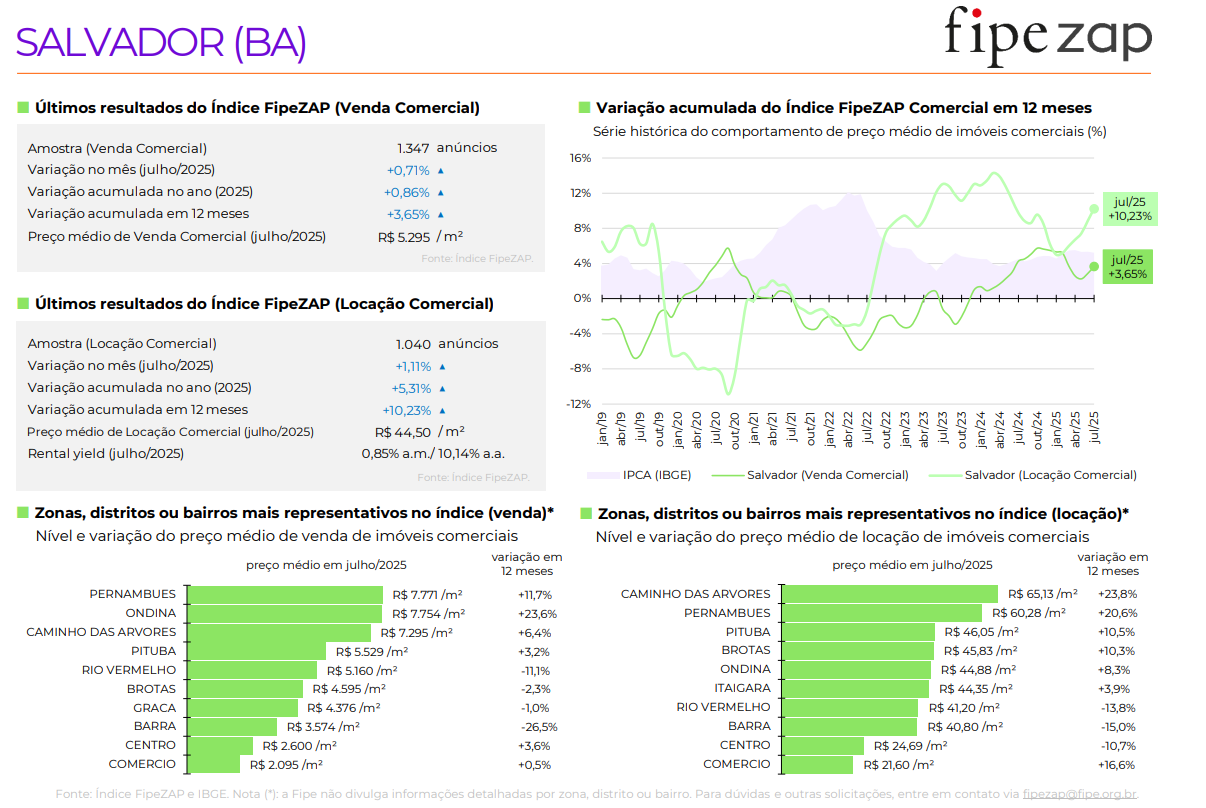)

## Pontos de destaque:
* Preço médio: R$ 44,50/m²

* Variação no mês: +1,11%

* Variação acumulada no ano: +5,31%

* Variação acumulada em 12 meses: +10,23%

* Rental Yield (retorno anual com aluguel): 10,14% a.a.
 Isso significa que em salvador os alugueis aumentam em até 10¢ em um único ano.

Não houveram menções em relação a cidade de recife.


# ÍNDICE DE PONTECIAL DE CONSUMO.
A princípio foi pensado uitilizar o IPC Maps 2025, pois fornece o pontencial de consumo de mais de 5 mil municípios do país, po´rem a sua versão gratuita não fornce dados apenas de algumns municípios da cidade do Rio de Janeiro.
Por ventura, o site Moviemtno econômico publicou um matéria sobre o pontecial de consumo da região Nordeste. A partir dos dados fornecidos será criado um dataframe para melhor apresentação.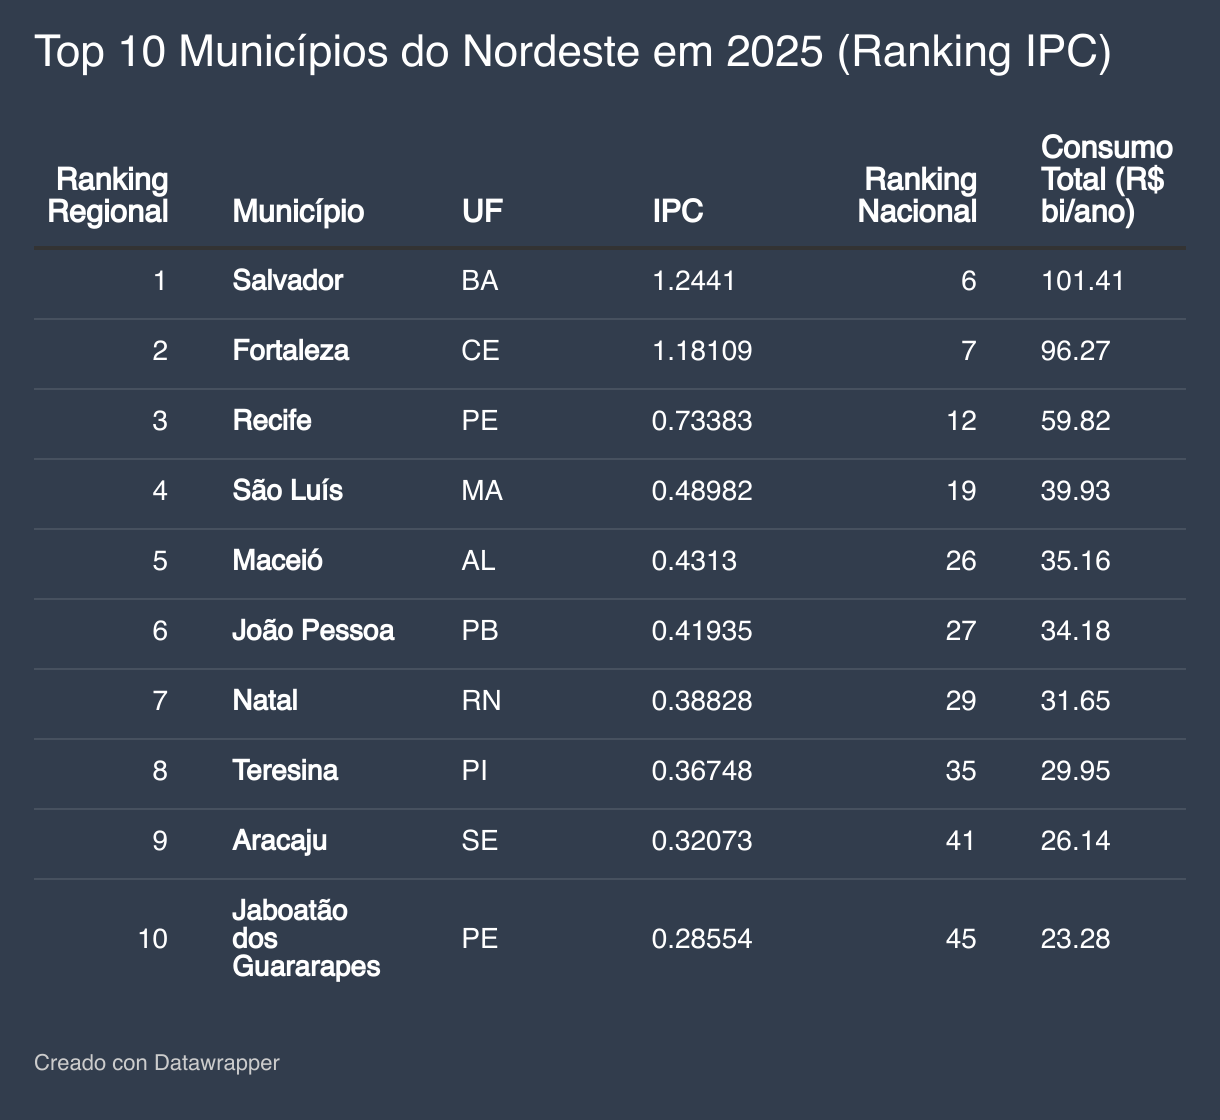

In [42]:
# Criando o dataframe
ipc_ne = {
    'Municipio': ['Salvador', 'Fortaleza', 'Recife', 'São Luís', 'Maceió',
                 'João Pessoa', 'Natal', 'Teresina', 'Aracaju', 'Jaboatão dos Guararapes'],
    'UF': ['BA', 'CE', 'PE', 'MA', 'AL', 'PB', 'RN', 'PI', 'SE', 'PE'],
    'IPC': [1.2441, 1.18109, 0.73383, 0.48982, 0.4313,
           0.41935, 0.38828, 0.36748, 0.32073, 0.28554],
}

df_ipc_ne = pd.DataFrame(ipc_ne)
print(df_ipc_ne)


                 Municipio  UF      IPC
0                 Salvador  BA  1.24410
1                Fortaleza  CE  1.18109
2                   Recife  PE  0.73383
3                 São Luís  MA  0.48982
4                   Maceió  AL  0.43130
5              João Pessoa  PB  0.41935
6                    Natal  RN  0.38828
7                 Teresina  PI  0.36748
8                  Aracaju  SE  0.32073
9  Jaboatão dos Guararapes  PE  0.28554


#Criação de gráficos.


In [43]:
# Filtrar dados por cidade de origem
salvador = df_voos[df_voos['Origem'] == 'Salvador']
recife = df_voos[df_voos['Origem'] == 'Recife']

# Criar gráfico de barras lado a lado
fig = go.Figure()

fig.add_trace(go.Bar(
    x=salvador['Destino'],
    y=salvador['Tempo_h'],
    name='Salvador',
    marker_color='orange'
))

fig.add_trace(go.Bar(
    x=recife['Destino'],
    y=recife['Tempo_h'],
    name='Recife',
    marker_color='blue'
))

# Layout do gráfico
fig.update_layout(
    barmode='group',  # lado a lado
    title='Comparação de tempos de voo entre Salvador e Recife para capitais do Nordeste',
    xaxis_title='Destino',
    yaxis_title='Tempo de voo (h)',
    legend_title='Cidade de origem'
)

fig.show()

In [44]:
import plotly.graph_objects as go

# Gráfico de barras interativo
fig = go.Figure()

fig.add_trace(go.Bar(
    x=comparacao["Cidade"],
    y=comparacao["mean"],
    text=[f"R$ {v:.2f}" for v in comparacao["mean"]],
    textposition="outside",
    marker=dict(color=["royalblue", "darkorange"])
))

fig.update_layout(
    title="Comparação do Aluguel Médio por m² - Salvador x Recife",
    yaxis_title="Aluguel Médio por m² (R$)",
    xaxis_title="Cidade",
    bargap=0.4,
    template="plotly_white"
)

fig.show()


In [45]:
#Grafico de barras municípios IPC
fig = go.Figure()

fig.add_trace(go.Bar(
    y=df_ipc_ne['Municipio'],
    x=df_ipc_ne['IPC'],
    orientation='h',
    text=df_ipc_ne['IPC'].round(3),
    textposition='auto',
))

# Personalizar o layout
fig.update_layout(
    title={
        'text': 'Índice de Potencial de Consumo (IPC) das pricnipais cidades do Nordeste',
    },
    xaxis_title='Índice de Potencial de Consumo (IPC)',
    yaxis_title='Município',
    plot_bgcolor='white',
    height=500,
    width=800,
    yaxis={'categoryorder': 'total ascending'}
)



# Resultado da análise do cenário.
##1.Qual das duas cidades apresenta a localização mais estratégica para a empresa?
* Salvador apresentou a melhor relação de custo benefício
##2.Quais são os principais fatores que sustentam essa decisão?
* Por mais que Recife tenha um tempo de voo menor para as demais capitais do Nordeste a localização de Salvador permite uma integração com as regiões Sudeste e Centro-Oeste, além de não haver uma disparidade muito grande em relação os tempos de voos.
* O custo por m² de aluguel de pontos comerciais de Salvador é cerca de R 35,72/m², já Recife R 26,60/m². A primeiro momento Salvador estaria em desvantagem, porém o índice de Fipe Zipe mostra que ao longo de 12 meses os preços de alugueis aumentaram cerca de 10%, o que pode ser provocado pela aumento de demandas por parte de investidores ou empreendedores que é sinal de que a cidade está se desenvolvendo economicamente ou estabelecendo políticas de incentivos fiscais.
* Salvador possui maior índice IPC do Nordeste, cerca de 1,244, que é cerca de 0,6948 maior que o de Salvador, com 0,734. Esse fato coloca Salvador como a melhor opção mesmo com as desvantagens em relação ao tempo de voo e custos com aluguel, pois por já se encontrar em um meio de grande potencial de consumo não haverá custos por entregas interestaduais.
##3.Quais ferramentas e metodologias foram utilizadas para fundamentar o seu case?
* Analise quantitativa do IPC e de Custos Operacionais por meio do comparativo de aluguéis.
* Análise de Dados Espaciais - Georreferenciamento estratégico com a biblioteca geopy.